## Zillow Exercises

In [81]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from env import host, user, password

Let's set up an example scenario as perspective for our regression exercises using the Zillow dataset.

As a Codeup data science graduate, you want to show off your skills to the Zillow data science team in hopes of getting an interview for a position you saw pop up on LinkedIn. You thought it might look impressive to build an end-to-end project in which you use some of their Kaggle data to predict property values using some of their available features; who knows, you might even do some feature engineering to blow them away. Your goal is to predict the values of single unit properties using the obervations from 2017.

In these exercises, you will complete the first step toward the above goal: acquire and prepare the necessary Zillow data from the zillow database in the Codeup database server.

1. Acquire bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, and fips from the zillow database for all 'Single Family Residential' properties.

In [62]:
# Connect to SQL database
def get_db_url(db_name):
    '''
    This function contacts Codeup's SQL database and uses the info from 
    my env to create a connection URL.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db_name}'

In [63]:
# Get Zillow data

def get_zillow_data():
    '''
    This function reads the zillow data from Codeup database to a dataframe,
    and returns the dataframe.
    '''
    # SQL query
    sql_query =  '''
            
    SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips
    FROM properties_2017
    LEFT JOIN propertylandusetype USING(propertylandusetypeid)
    WHERE propertylandusedesc IN ("Single Family Residential",                       
                                  "Inferred Single Family Residential")'''
    
    # Read in DataFrame
    df = pd.read_sql(sql_query, get_db_url('zillow'))
    
    df = df.rename(columns = {'bedroomcnt': 'num_beds',
                                      'bathroomcnt': 'num_baths',
                                      'calculatedfinishedsquarefeet': 'square_footage',
                                      'taxvaluedollarcnt': 'tax_value',
                                      'yearbuilt': 'year_built', 'taxamount': 'tax_amount'})
    return df


In [64]:
# Simpler SQL without JOINS would be: 
#     SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, 
#                    taxvaluedollarcnt, yearbuilt, taxamount, fips, propertylandusetypeid
#                FROM properties_2017
#                WHERE propertylandusetypeid LIKE '261' OR propertylandusetypeid LIKE '279'

In [65]:
df = get_zillow_data()
df.head()

,num_beds,num_baths,square_footage,tax_value,year_built,tax_amount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


2. Using your acquired Zillow data, walk through the summarization and cleaning steps in your wrangle.ipynb file like we did above. You may handle the missing values however you feel is appropriate and meaninful; remember to document your process and decisions using markdown and code commenting where helpful.


In [66]:
df.shape

(2152864, 7)

In [67]:
# Check summary stats
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_beds,2152853.0,3.287195,0.954757,0.00,3.0000,3.000,4.0000,25.00
num_baths,2152853.0,2.230687,0.999281,0.00,2.0000,2.000,3.0000,32.00
square_footage,2144379.0,1862.855178,1222.125124,1.00,1257.0000,1623.000,2208.0000,952576.00
tax_value,2152371.0,461896.052361,699675.940049,1.00,188170.0000,327671.000,534527.0000,98428909.00
year_built,2143526.0,1960.949681,22.162196,1801.00,1949.0000,1958.000,1976.0000,2016.00
tax_amount,2148422.0,5634.863752,8178.908996,1.85,2534.9725,4108.945,6414.3175,1337755.86
fips,2152864.0,6048.377330,20.433289,6037.00,6037.0000,6037.000,6059.0000,6111.00


Noticed there are some extreme outliers.

In [68]:
# Function to remove outliers
def remove_outliers(df, k, col_list):
    ''' 
        This function removes outliers from a list of columns in a df
        then reurns that df. 
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe sans outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df


In [69]:
 df = remove_outliers(df, 1.5, ['num_beds', 'num_baths', 'square_footage', 'tax_value', 'year_built', 'tax_amount'])

In [70]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_beds,1799545.0,3.219901,0.777372,2.00,3.00,3.00,4.00,5.00
num_baths,1799545.0,2.060948,0.699571,1.00,2.00,2.00,2.50,4.00
square_footage,1799545.0,1653.425259,562.065770,1.00,1232.00,1548.00,1984.00,3410.00
tax_value,1799545.0,328068.685584,198102.467996,22.00,174331.00,297522.00,452274.00,950940.00
year_built,1799545.0,1960.104878,18.852253,1915.00,1950.00,1957.00,1972.00,2006.00
tax_amount,1799545.0,4066.124662,2227.213122,16.48,2374.73,3751.14,5478.11,10329.43
fips,1799545.0,6048.524272,20.651374,6037.00,6037.00,6037.00,6059.00,6111.00


The outliers have now been removed. 

In [71]:
# Check for NULLS in each column
df.isnull().sum()

num_beds          0
num_baths         0
square_footage    0
tax_value         0
year_built        0
tax_amount        0
fips              0
dtype: int64

Note: Removing the outliers got rid of the NULLS in every category.

In [72]:
# Drop duplicates

print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(1799545, 7)
(1790607, 7)


In [73]:
# check datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1790607 entries, 7 to 2152854
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   num_beds        float64
 1   num_baths       float64
 2   square_footage  float64
 3   tax_value       float64
 4   year_built      float64
 5   tax_amount      float64
 6   fips            float64
dtypes: float64(7)
memory usage: 109.3 MB


Going to convert num_beds, num_baths, square_footage, year_built, and flips to 'object'

In [74]:
# Convert 'float64' to 'object'
df.num_beds = df.num_beds.astype(object)
df.num_baths = df.num_baths.astype(object)
df.square_footage = df.square_footage.astype(object)
df.year_built = df.year_built.astype(object)
df.fips = df.fips.astype(object)

In [75]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1790607 entries, 7 to 2152854
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   num_beds        object 
 1   num_baths       object 
 2   square_footage  object 
 3   tax_value       float64
 4   year_built      object 
 5   tax_amount      float64
 6   fips            object 
dtypes: float64(2), object(5)
memory usage: 109.3+ MB


Steps in Prep: 
   
   - Remove Outliers
   - Removing outliers removed NULLS so no NULLS
   - Remove duplicates
   - Correct datatypes 

In [76]:
def get_hist(df):
    ''' Gets histographs of acquired continuous variables'''
    
    plt.figure(figsize=(16, 3))

    # List of columns
    cols = [col for col in df.columns if col not in ['fips', 'year_built']]

    for i, col in enumerate(cols):

        # i starts at 0, but plot nos should start at 1
        plot_number = i + 1 

        # Create subplot.
        plt.subplot(1, len(cols), plot_number)

        # Title with column name.
        plt.title(col)

        # Display histogram for column.
        df[col].hist(bins=5)

        # Hide gridlines.
        plt.grid(False)

        # turn off scientific notation
        plt.ticklabel_format(useOffset=False)

        plt.tight_layout()

    plt.show()

In [77]:
def get_box(df):
    ''' Gets boxplots of acquired continuous variables'''
    
    # List of columns
    cols = ['num_beds', 'num_baths', 'square_footage', 'tax_value', 'tax_amount']

    plt.figure(figsize=(16, 3))

    for i, col in enumerate(cols):

        # i starts at 0, but plot should start at 1
        plot_number = i + 1 

        # Create subplot.
        plt.subplot(1, len(cols), plot_number)

        # Title with column name.
        plt.title(col)

        # Display boxplot for column.
        sns.boxplot(data=df[[col]])

        # Hide gridlines.
        plt.grid(False)

        # sets proper spacing between plots
        plt.tight_layout()

    plt.show()

3. Store all of the necessary functions to automate your process from acquiring the data to returning a cleaned dataframe witn no missing values in your wrangle.py file. Name your final function wrangle_zillow.


In [82]:
def prepare_zillow(df):
    ''' Prepare zillow data for exploration'''

    # removing outliers
    df = remove_outliers(df, 1.5, ['num_beds', 'num_baths', 'square_footage', 'tax_value', 'year_built', 'tax_amount'])
    
    # Drop duplicates
    df = df.drop_duplicates()
    
    # converting column datatypes
    df.num_beds = df.num_beds.astype(object)
    df.num_baths = df.num_baths.astype(object)
    df.square_footage = df.square_footage.astype(object)
    df.year_built = df.year_built.astype(object)
    df.fips = df.fips.astype(object)
    
    # get distributions of numeric data
    get_hist(df)
    get_box(df)
    
    # train/validate/test split
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
    

    return train, validate, test 

In [89]:
def wrangle_zillow():
    '''
    This function will both aquire and prepare the zillow data.
    It displays the histogram and boxplots before splitting the df.
    After running this function the data is ready for exploritory analysis.
    '''
    train, validate, test = prepare_zillow(get_zillow_data())
    
    return train, validate, test

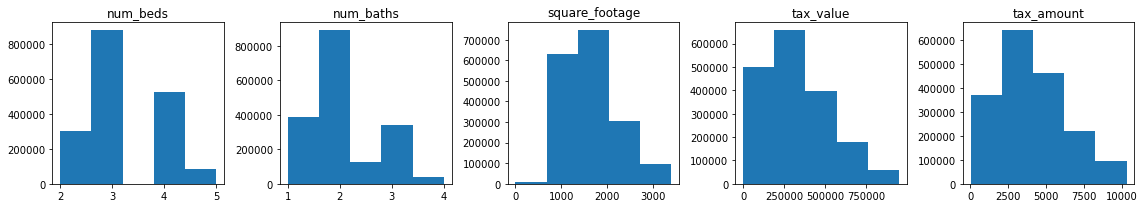

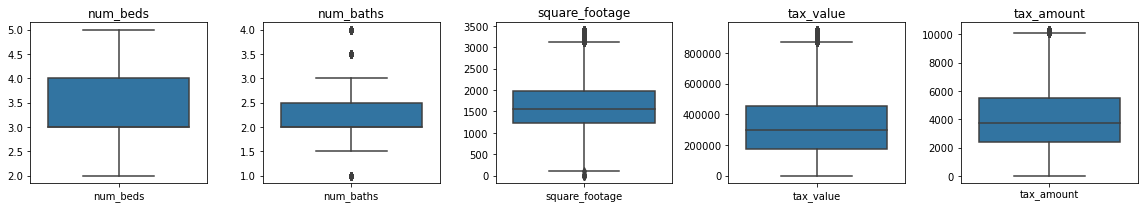

In [84]:
train, validate, test = wrangle_zillow()

In [85]:
train.head()

,num_beds,num_baths,square_footage,tax_value,year_built,tax_amount,fips
1852198,4.0,2.0,1986.0,267140.0,1963.0,2824.78,6111.0
126219,3.0,1.0,877.0,82067.0,1953.0,1235.32,6059.0
855070,4.0,3.0,1972.0,159374.0,1942.0,2091.75,6037.0
1569772,4.0,2.0,1309.0,497923.0,1956.0,5623.58,6059.0
80997,3.0,2.0,1512.0,205712.0,1951.0,2729.58,6037.0


In [86]:
train.shape

(1002739, 7)

In [87]:
validate.shape

(429746, 7)

In [88]:
test.shape

(358122, 7)